In [1]:
# Packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import time
from sklearn.ensemble import AdaBoostClassifier

# Pipeline
from tree import TreeModel

# ===== import data; tr,ts ======
X_tr = pd.read_csv('split-data/processed/X_tr.csv')
X_ts = pd.read_csv('split-data/processed/X_ts.csv')
y_tr = pd.read_csv('split-data/processed/y_tr.csv')
y_ts = pd.read_csv('split-data/processed/y_ts.csv')

In [6]:
# ===== AdaBoost ======
start = time.time()

ab_params = {
    'X_tr': X_tr.to_numpy(),
    'X_ts': X_ts.to_numpy(),
    'y_tr': y_tr.values.ravel(),
    'y_ts': y_ts.values.ravel(),
    'model': AdaBoostClassifier(algorithm='SAMME'), # Avoid warning associated w/ default model
    'name': 'AdaBoost'
}

ab_pipeline = TreeModel(**ab_params)

ab_fit_params = {
    'param_grid': {
        'n_estimators': [10, 50, 100, 200, 500, 1000, 2000],
        'learning_rate': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
    },
    'balance_classes': False,
    'k_folds': 2,
    'scoring': 'accuracy'
}

ab_pipeline.fit_predict(**ab_fit_params)

end = time.time()
elapsed = end - start
print(f"Elapsed time: {elapsed:.2f} seconds")

Elapsed time: 377.70 seconds


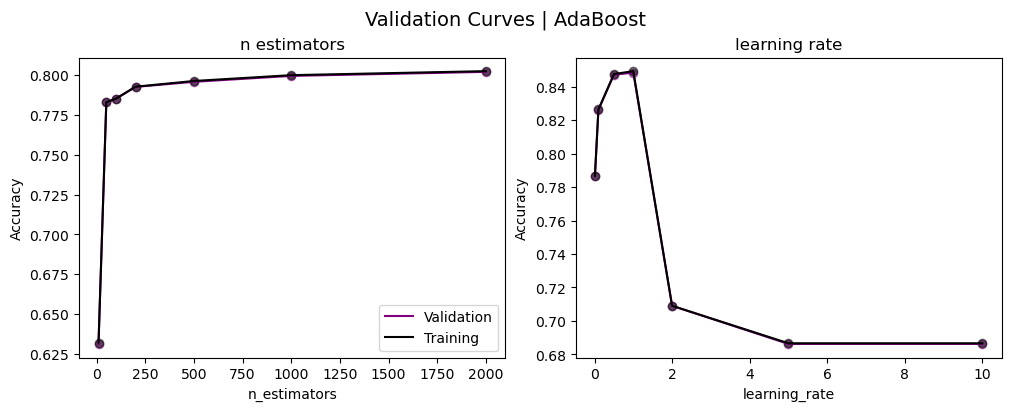

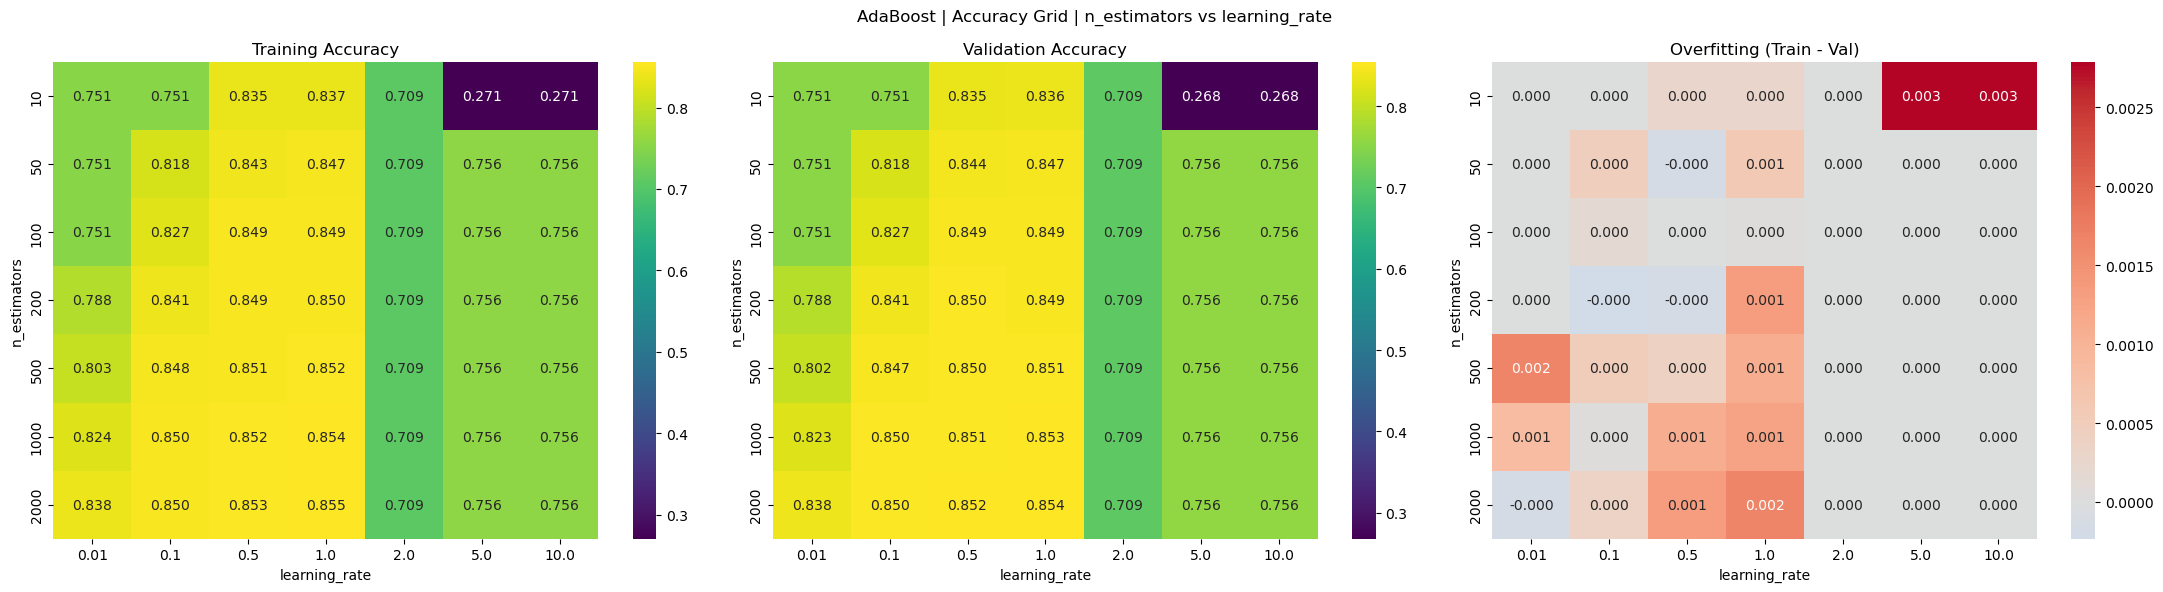

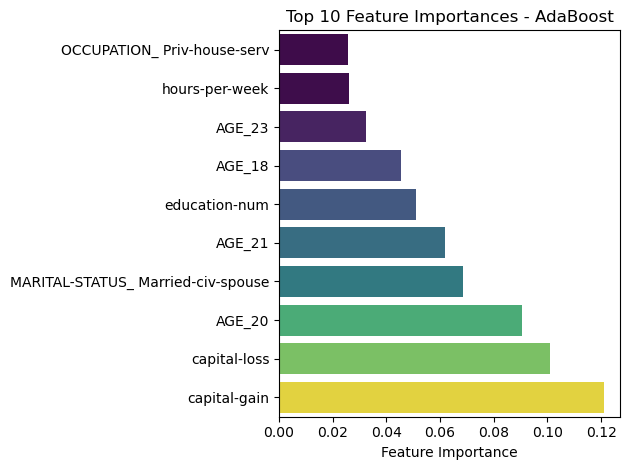

In [7]:
# ===== AdaBoost Scoring & Visualization ======
os.makedirs('media/04_adaboost', exist_ok=True)

plot_vhgr_params = {
    'param_list': ab_pipeline.hyper_grid,
    'figsize': (5, 4),
    'save_path': 'media/04_adaboost/balanced_validation_curves.png'
}
ab_pipeline.plot_validation_hyperparam_grid_row(**plot_vhgr_params)

ab_pipeline.viz_heatmap_cv(
    top_two_params_for_overfitting=['n_estimators', 'learning_rate'],
    dir_save_path='media/04_adaboost'
)

# ===== AdaBoost Feature Importances ======
k = 10
best_ab = ab_pipeline.grid.best_estimator_

ab_importances = pd.Series(best_ab.feature_importances_, index=X_tr.columns)
top_features = ab_importances.sort_values(ascending=False).head(k)

sns.barplot(
    x=top_features.sort_values().values,
    y=top_features.sort_values().index,
    hue=top_features.sort_values().values,
    dodge=False,
    palette='viridis',
    legend=False
)

plt.title(f"Top {k} Feature Importances - AdaBoost")
plt.xlabel("Feature Importance")
plt.ylabel('')
plt.tight_layout()
plt.savefig('media/04_adaboost/significant_features_viz.png')
plt.show()

Overfitting is very hard with AdaBoost (assuming we use default model w/ stump decision trees -> if we increase max_depth of each decision tree then this is a different story).